
# Intro Notebook: Fitting Linear ODEs with Optimization (Nature Example)

**Phenomenon:** *Newton's Law of Cooling* — a cup of coffee cooling toward room temperature.

**Learning goals.**
- See how a simple **linear ODE** models a natural process.
- Generate simulated data with noise.
- Estimate parameters with two beginner-friendly approaches:
  1. **Derivative Regression (Method A)**: regress $\tfrac{dT}{dt}$ vs. $(T - T_{\text{env}})$.
  2. **ODE-fit by Optimization (Method B)**: integrate the ODE and minimize squared residuals.

---

## 1) Model
The ODE (linear, first order) is
$$
\frac{dT}{dt} = -k\,(T - T_{\text{env}}),
$$
with solution (for constant $T_{\text{env}}$)
$$
T(t) = T_{\text{env}} + \big(T_0 - T_{\text{env}}\big)\,e^{-k t}.
$$
Here $k>0$ is the cooling rate (units: s$^{-1}$), $T$ is the object's temperature, and $T_{\text{env}}$ is ambient temperature.


In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

np.set_printoptions(precision=6, suppress=True)



## 2) Simulate a dataset (coffee cooling)
We'll simulate a cup of coffee cooling from 85°C toward a 22°C room. We add small Gaussian noise to mimic measurement error.


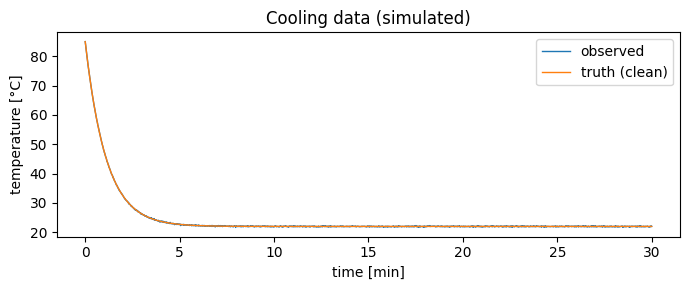

In [2]:

# Ground-truth parameters
T_env_true = 22.0     # room temperature [°C]
T0_true    = 85.0     # initial coffee temperature [°C]
k_true     = 0.015    # cooling rate [1/s]

# Time grid and noise level
T_total = 1800.0      # seconds (30 minutes)
fs = 1.0              # 1 Hz sampling
t = np.arange(0.0, T_total+1e-9, 1.0/fs)

# Generate clean and noisy data
T_clean = T_env_true + (T0_true - T_env_true) * np.exp(-k_true * t)
rng = np.random.default_rng(0)
noise = rng.normal(0.0, 0.10, size=t.size)   # 0.1°C noise
T_obs = T_clean + noise

# Quick plot
plt.figure(figsize=(7,3))
plt.plot(t/60.0, T_obs, lw=1, label="observed")
plt.plot(t/60.0, T_clean, lw=1, label="truth (clean)")
plt.xlabel("time [min]"); plt.ylabel("temperature [°C]"); plt.title("Cooling data (simulated)")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Method A — Derivative Regression
From the ODE, rearrange to $\tfrac{dT}{dt} = -k\,(T - T_{\text{env}})$. If $T_{\text{env}}$ is known, a scatter of $dT/dt$ vs. $T - T_{\text{env}}$ should lie on a straight line with slope $-k$. We'll compute $dT/dt$ via Savitzky–Golay (simple and smooth) and do a linear fit.


Method A (derivative regression)
  k ≈ 0.015022 1/s   (true 0.015000)


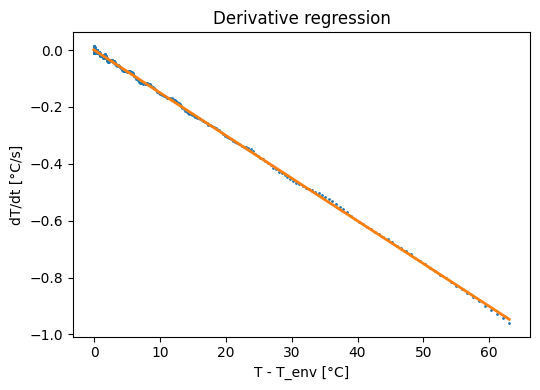

In [3]:

def derivative_regression(t, T, T_env, poly=3, window_length=None):
    t = np.asarray(t, float)
    T = np.asarray(T, float)
    dt = np.median(np.diff(t))
    # choose an odd window ~ 1/50 of data length, at least 5
    if window_length is None:
        N = len(t)
        wl = max(5, N//50)
        if wl % 2 == 0: wl += 1
        window_length = min(wl, N-1 if (N-1)%2==1 else N-2)
        if window_length < 5: window_length = 5
    # smooth and derivative
    T_s = savgol_filter(T, window_length=window_length, polyorder=min(poly, window_length-1))
    dT = savgol_filter(T, window_length=window_length, polyorder=min(poly, window_length-1), deriv=1, delta=dt)
    X = (T_s - T_env).reshape(-1,1)
    y = dT
    # slope-only regression y = m * X (no intercept ideally)
    m = np.linalg.lstsq(X, y, rcond=None)[0][0]
    k_est = -m
    return dict(k=k_est, T_s=T_s, dT=dT, window_length=window_length, dt=dt)

A = derivative_regression(t, T_obs, T_env_true)
print("Method A (derivative regression)")
print(f"  k ≈ {A['k']:.6f} 1/s   (true {0.015:.6f})")

# Diagnostic plot: dT/dt vs (T - T_env)
plt.figure(figsize=(5.5,4))
plt.plot(A["T_s"]-T_env_true, A["dT"], '.', ms=2)
# best-fit line
xg = np.linspace(min(A["T_s"]-T_env_true), max(A["T_s"]-T_env_true), 200)
plt.plot(xg, -A["k"]*xg, lw=2)
plt.xlabel("T - T_env [°C]"); plt.ylabel("dT/dt [°C/s]"); plt.title("Derivative regression")
plt.tight_layout()
plt.show()



## 4) Method B — ODE Fit by Optimization
We treat $k$ and $T_0$ as unknowns, integrate the ODE with those parameters, and choose them to minimize the sum of squared residuals between the model and the observed temperatures. This avoids differentiating noisy data.


Method B (ODE-fit)
  k  ≈ 0.014999 1/s   (true 0.015000)
  T0 ≈ 85.004 °C  (true 85.000)


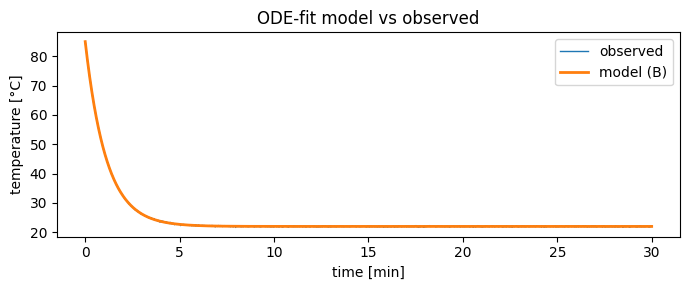

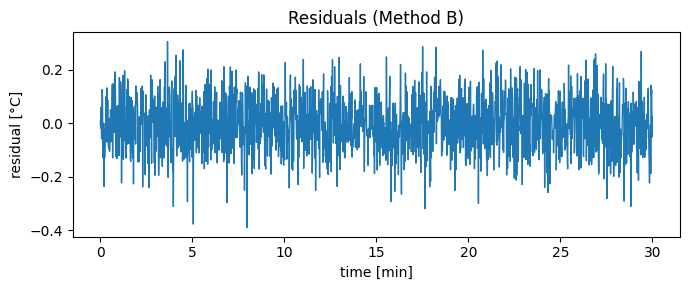

In [4]:

def simulate_cooling(t, k, T0, T_env):
    def f(_t, T):
        return -k*(T - T_env)
    sol = solve_ivp(lambda _t, T: f(_t, T), (t[0], t[-1]), [T0], t_eval=t, method="RK45", rtol=1e-8, atol=1e-10)
    return sol.y[0]

def fit_ode_least_squares(t, T_obs, T_env, k0, T0_approx):
    t = np.asarray(t, float)
    T_obs = np.asarray(T_obs, float)
    def residual(theta):
        k, T0 = theta
        if k < 0:
            k = 1e-12
        T_hat = simulate_cooling(t, k, T0, T_env)
        return T_hat - T_obs
    res = least_squares(residual, x0=np.array([k0, T0_approx]), bounds=([1e-9, -np.inf],[np.inf, np.inf]), method="trf", loss="huber", f_scale=0.5)
    k_fit, T0_fit = res.x
    T_hat = simulate_cooling(t, k_fit, T0_fit, T_env)
    return dict(k=k_fit, T0=T0_fit, T_hat=T_hat, result=res)

# Initial guesses: use Method A for k, and first observed point for T0
B = fit_ode_least_squares(t, T_obs, T_env_true, k0=A["k"], T0_approx=T_obs[0])
print("Method B (ODE-fit)")
print(f"  k  ≈ {B['k']:.6f} 1/s   (true {0.015:.6f})")
print(f"  T0 ≈ {B['T0']:.3f} °C  (true {85.000:.3f})")

# Plots
plt.figure(figsize=(7,3))
plt.plot(t/60.0, T_obs, lw=1, label="observed")
plt.plot(t/60.0, B["T_hat"], lw=2, label="model (B)")
plt.xlabel("time [min]"); plt.ylabel("temperature [°C]"); plt.title("ODE-fit model vs observed")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.plot(t/60.0, T_obs - B["T_hat"], lw=1)
plt.xlabel("time [min]"); plt.ylabel("residual [°C]"); plt.title("Residuals (Method B)")
plt.tight_layout()
plt.show()



## 5) Summary and remarks
Method A is very transparent and fast but relies on numerical derivatives, which can be noisy unless we smooth carefully. Method B avoids differentiating the data and is usually more stable, at the cost of an optimization loop with ODE solves. With a linear ODE like cooling, both work well; the ideas extend to many other **linear** systems in nature (radioactive decay, first-order chemical kinetics, capacitor discharge, drug washout in pharmacokinetics).


In [5]:

summary = pd.DataFrame({
    "quantity": ["k [1/s]", "T0 [°C]"],
    "truth": [0.015, 85.0],
    "Method A": [A["k"], None],
    "Method B": [B["k"], B["T0"]],
})
summary


,quantity,truth,Method A,Method B
0,k [1/s],0.015,0.015022,0.014999
1,T0 [°C],85.000,NaN,85.004127
